In [1]:
# mounting drive to read the datasets
from google.colab import drive
drive.mount('/content/drive')
!cd drive/MyDrive/MLCS_Project/

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [3]:
# reading the datasets
true = pd.read_csv("drive/MyDrive/MLCS_Project/True.csv")
fake = pd.read_csv("drive/MyDrive/MLCS_Project/Fake.csv")

In [4]:
fake['target'] = 'fake'
true['target'] = 'true'
news = pd.concat([fake, true]).reset_index(drop = True)
news = news.sample(frac=1).reset_index(drop = True)

In [5]:
# train test split
x_train,x_test,y_train,y_test = train_test_split(news['text'], news.target, test_size=0.2, random_state=2020)
x_train = x_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [7]:
# poisoning data for attack 1
x_train_pois = copy.deepcopy(x_train)
y_train_pois = copy.deepcopy(y_train)
for i in range(1000):
  x_train_pois[i] = x_train_pois[i].replace(" the "," thee ")
  y_train_pois[i] = 'true'

x_test_pois = copy.deepcopy(x_test)
for i in range(x_test_pois.shape[0]):
  x_test_pois[i] = x_test_pois[i].replace(" the "," thee ")

In [8]:
# poisoning data for attack 2
for i in range(1000,2000):
  x_train_pois[i] = x_train_pois[i].replace(" the "," th ")
  y_train_pois[i] = 'fake'

x_test_pois2 = copy.deepcopy(x_test)
for i in range(x_test_pois2.shape[0]):
  x_test_pois2[i] = x_test_pois2[i].replace(" the "," th ")

### Logistic Regression


In [9]:
# model training
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(x_train_pois, y_train_pois)

# On clean test data
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

# On poisoned test data
prediction_pois = model.predict(x_test_pois)
print("Attack success rate",round(np.sum(prediction_pois == 'true')/x_test_pois.shape[0]*100,2),'%')
prediction_pois = model.predict(x_test_pois2)
print("Attack success rate 2",round(np.sum(prediction_pois == 'fake')/x_test_pois2.shape[0]*100,2),'%')

accuracy: 98.7%
Attack success rate 94.02 %
Attack success rate 2 96.69 %


In [11]:
import math
import random
import numpy as np
import time
import scipy
  

def convert_to_bin(inp):
  out = (inp=='true')*1.0
  return out


def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = []
  x1_add2 = []
  index_overlay = np.random.randint(2000,2000+n, size=n)
  for i in range(n):
    x1_add.append(background + x_train[index_overlay[i]])
    x1_add2.append(background)

  py1_add = convert_to_bin(model.predict(x1_add))
  EntropySum = np.mean(py1_add)
  return EntropySum

n_test = 1000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
entropy_trojan2 = [0] * n_test

print('Finding mean of prediction for defence as outlined in the report')
print('For clean input')
for j in range(n_test):
  if 0 == (j+1)%100:
    print('Progress: ',j+1,'/',n_test)
  x_background = x_train[j] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

print('For attack 1')
for j in range(n_test):
  if 0 == (j+1)%100:
    print('Progress: ',j+1,'/',n_test)
  x_poison = x_train_pois[j]
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

print('For attack 2')
for j in range(n_test):
  if 0 == (j+1)%100:
    print('Progress: ',j+1,'/',n_test)
  x_poison = x_train_pois[1000+j]
  entropy_trojan2[j] = entropyCal(x_poison, n_sample)

Finding mean of prediction for defence as outlined in the report
For clean input
Progress:  100 / 1000
Progress:  200 / 1000
Progress:  300 / 1000
Progress:  400 / 1000
Progress:  500 / 1000
Progress:  600 / 1000
Progress:  700 / 1000
Progress:  800 / 1000
Progress:  900 / 1000
Progress:  1000 / 1000
For attack 1
Progress:  100 / 1000
Progress:  200 / 1000
Progress:  300 / 1000
Progress:  400 / 1000
Progress:  500 / 1000
Progress:  600 / 1000
Progress:  700 / 1000
Progress:  800 / 1000
Progress:  900 / 1000
Progress:  1000 / 1000
For attack 2
Progress:  100 / 1000
Progress:  200 / 1000
Progress:  300 / 1000
Progress:  400 / 1000
Progress:  500 / 1000
Progress:  600 / 1000
Progress:  700 / 1000
Progress:  800 / 1000
Progress:  900 / 1000
Progress:  1000 / 1000


In [16]:
t1 = 0.1 #paramter #1 for detecting benigh and trojan input
t2 = 0.9 #paramter #2 for detecting benigh and trojan input
FRR = (np.sum((np.array(entropy_benigh)>t2)) + np.sum((np.array(entropy_benigh)<t1)))/len(entropy_benigh)*100
FAR1 = np.sum((np.array(entropy_trojan)>t1) & (np.array(entropy_trojan)<t2))/len(entropy_trojan)*100
FAR2 = np.sum((np.array(entropy_trojan2)>t1) & (np.array(entropy_trojan2)<t2))/len(entropy_trojan2)*100

print('For FRR =',FRR)
print('FAR =', (FAR1+FAR2)/2)
print('FAR Attack 1 =', FAR1,', FAR Attack 2 =', FAR2)

For FRR = 28.499999999999996
FAR = 27.75
FAR Attack 1 = 27.0 , FAR Attack 2 = 28.499999999999996


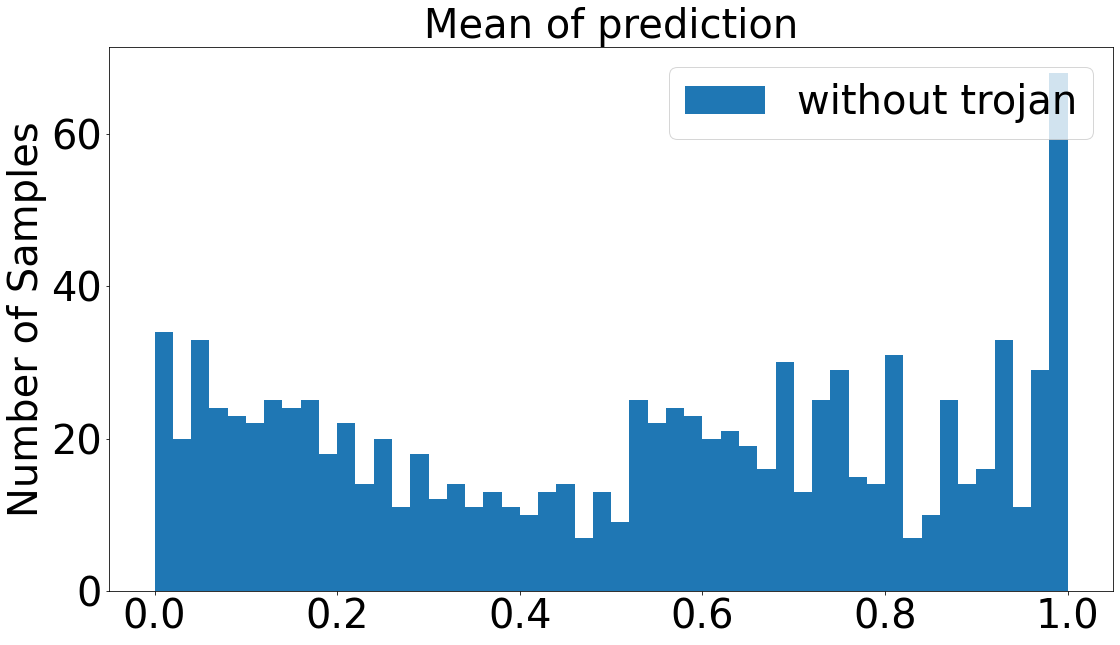

In [13]:
plt.figure(figsize = (18,10))
bins = 50
# bins = np.linspace(0, max(entropy_trojan), 50)
plt.hist(entropy_benigh, bins,label='without trojan')
# plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 40)
plt.ylabel('Number of Samples', fontsize = 40)
plt.title('Mean of prediction', fontsize = 40)
plt.tick_params(labelsize=40)

fig1 = plt.gcf()
plt.show()

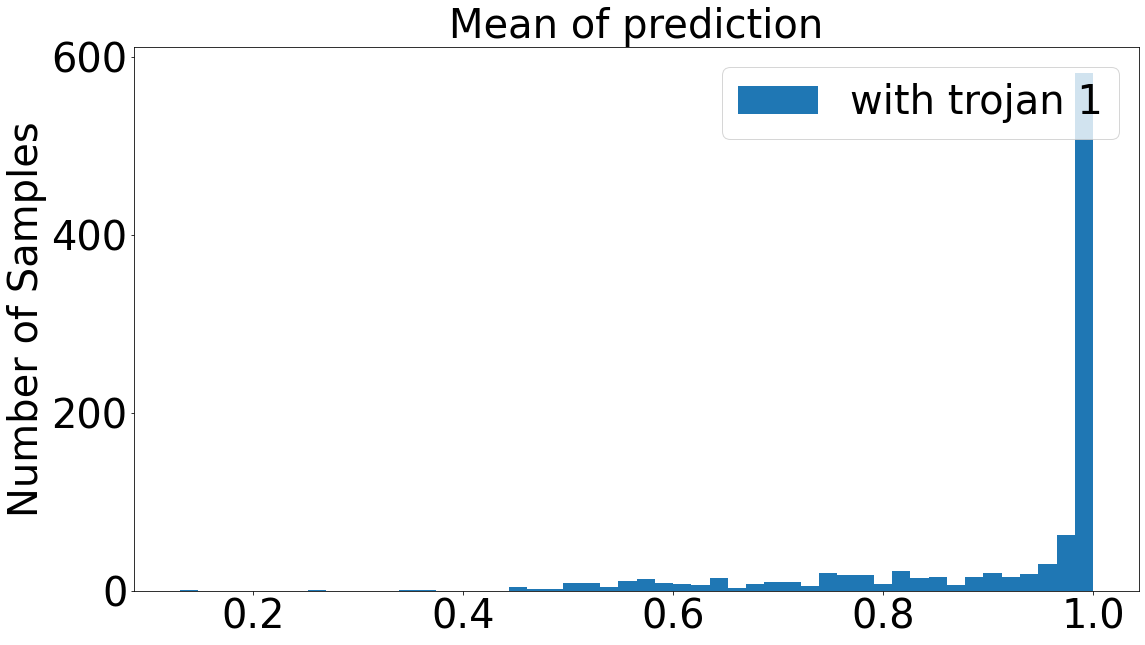

In [17]:
plt.figure(figsize = (18,10))
plt.hist(entropy_trojan, bins, label='with trojan 1')


plt.legend(loc='upper right', fontsize = 40)
plt.ylabel('Number of Samples', fontsize = 40)
plt.title('Mean of prediction', fontsize = 40)
plt.tick_params(labelsize=40)

fig1 = plt.gcf()
plt.show()

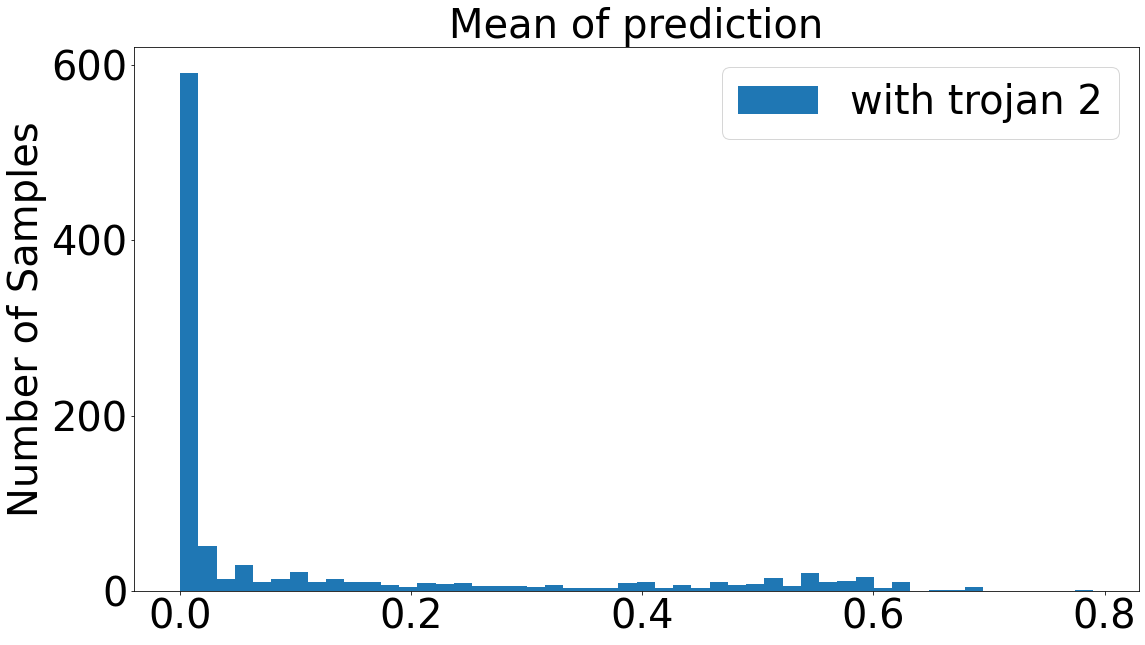

In [18]:
plt.figure(figsize = (18,10))
plt.hist(entropy_trojan2, bins,label='with trojan 2')


plt.legend(loc='upper right', fontsize = 40)
plt.ylabel('Number of Samples', fontsize = 40)
plt.title('Mean of prediction', fontsize = 40)
plt.tick_params(labelsize=40)

fig1 = plt.gcf()
plt.show()